<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/plot_top_losses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to showcase the newly added `plot_top_losses` functionality, which allows users to inspect models' results by plotting images sorted by various combinations of losses. This API makes it easy to immediately spot pictures the model struggles the most with, giving the practitioner the opportunity to take swift action to correct this behaviour (remove wrong samples, correct mis-labellings, etc).

`plot_top_losses` is available for all IceVision models, as the below notebook shows. 

## Install IceVision

In [1]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

# Object Detection

## Load `fridge` dataset

In [1]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [2]:
# Loading Data
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [3]:
# Parser
class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.voc(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)
# Records
train_records, valid_records = parser.parse()

WARNING  - This function will be deprecated, instantiate the concrete classes instead: `VOCBBoxParser`, `VOCMaskParser` | icevision.parsers.voc_parser:voc:17


  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

In [4]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [5]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [6]:
model_type = models.torchvision.faster_rcnn
backbone = model_type.backbones.resnet50_fpn

In [7]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=1, num_workers=4, shuffle=False)

## Train `faster_rcnn` model

In [8]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

In [9]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [10]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [11]:
learn.fine_tune(10, 1e-2, freeze_epochs=1)

/home/ubuntu/anaconda3/envs/ice/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Run `top_plot_losses` on `faster_rcnn` model results

Values allowed to pass to `sort_by` are (for `faster_rcnn`):



* `"loss_classifier"`
* `"loss_box_reg"`
* `"loss_objectness"`
* `"loss_rpn_box_reg"`
* `"loss_total"` (sum of the previous 4 losses)
* ```
  {"method": "weighted", 
  "weights": {"loss_box_reg": 0.25,
  "loss_classifier": 0.25,
  "loss_objectness": 0.25,
  "loss_rpn_box_reg": 0.25,}}
  ```
  (calculates weighted sum of the 4 losses - *Note*: I have set weights to `0.25` for example purposes)


Below we show several ways of invoking the same API on the trained model, sorting samples by different losses combinations.

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

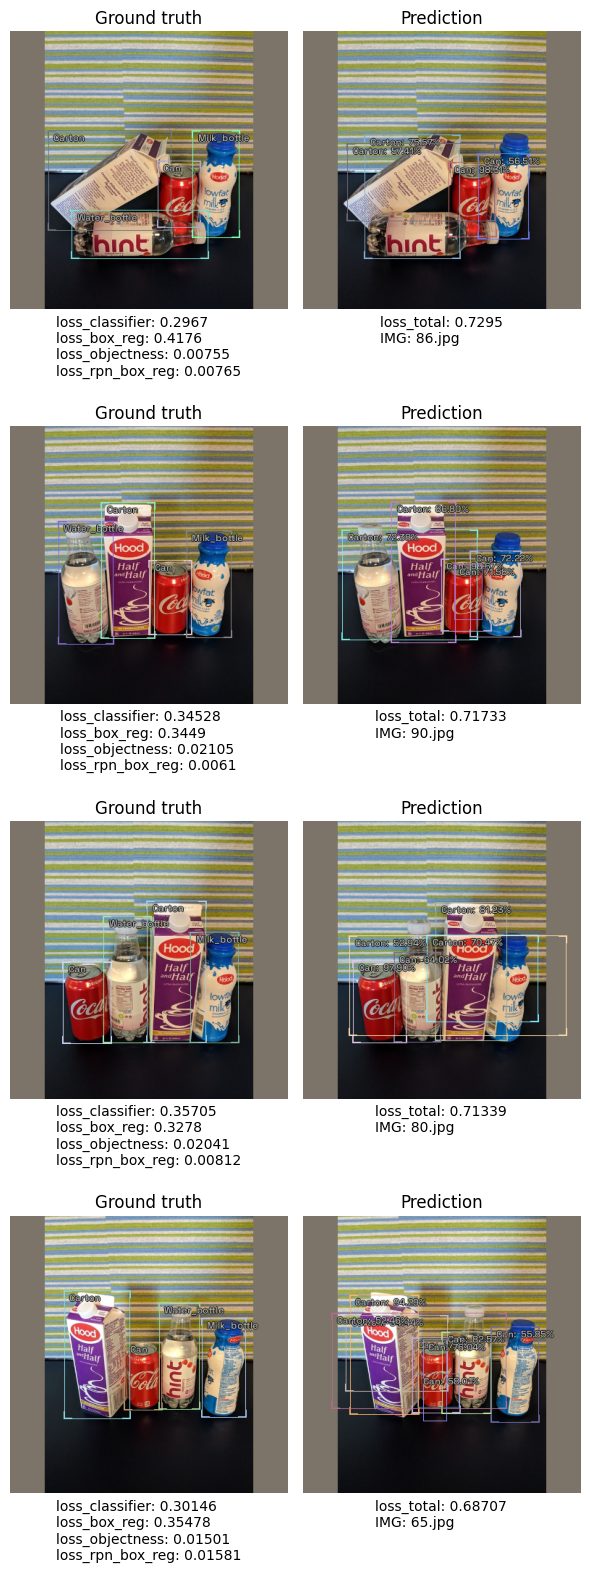

In [12]:
samples_plus_losses, preds, losses_stats = model_type.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by="loss_total", n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

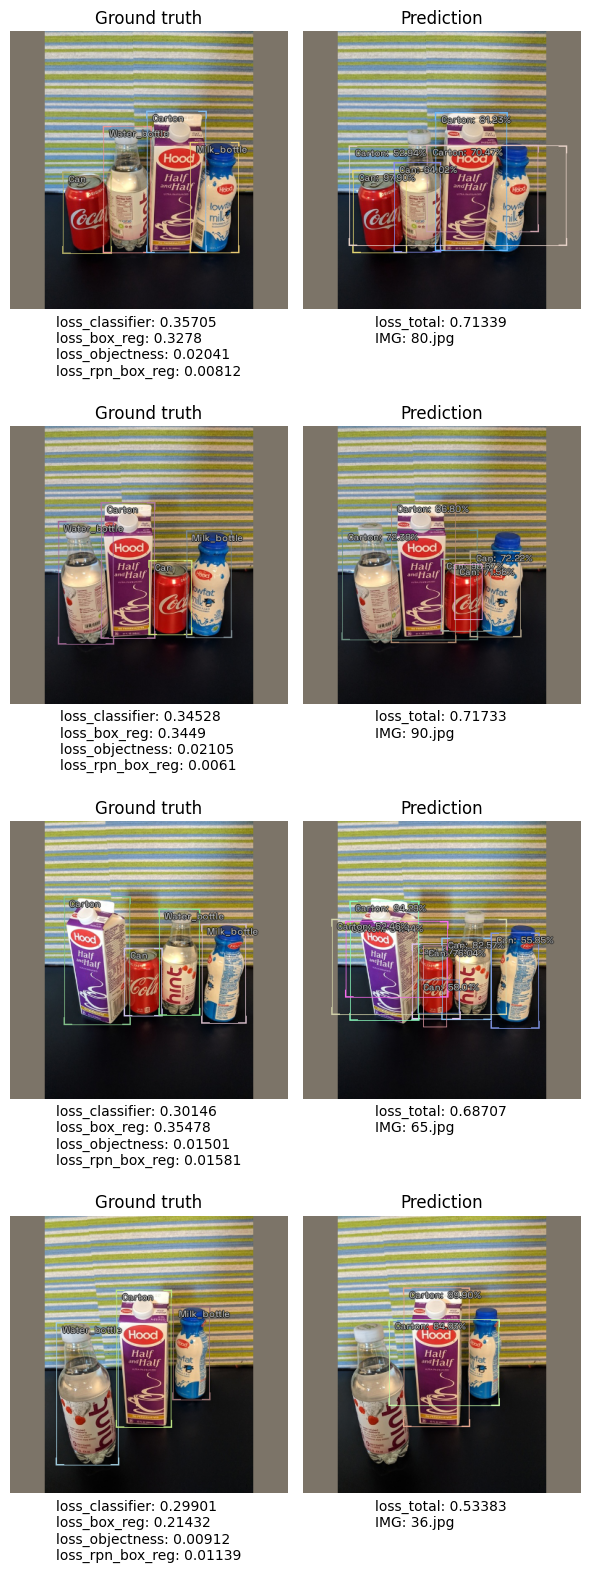

In [13]:
samples_plus_losses, preds, losses_stats = model_type.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by="loss_classifier", n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

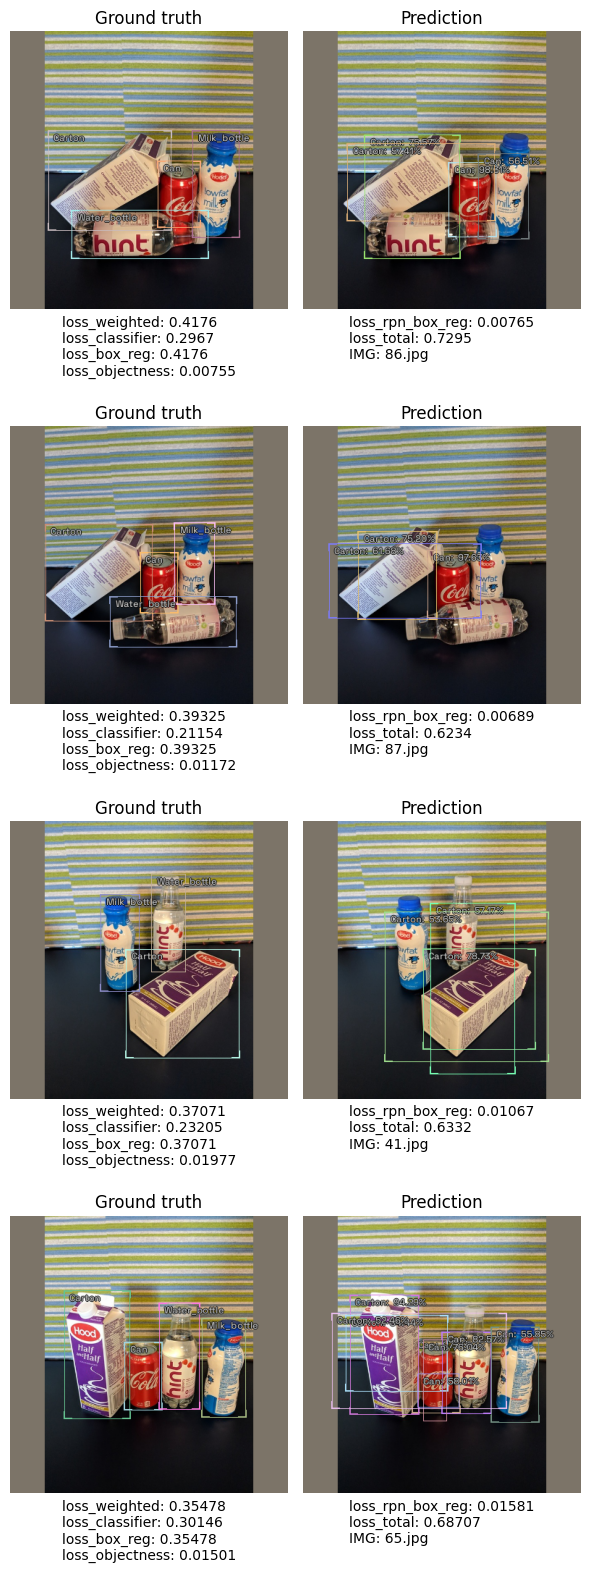

In [14]:
# in this case `loss_weighted` will be equal to `loss_box_reg`
by = {
        "method": "weighted",
        "weights": {
            "loss_box_reg": 1,
            "loss_classifier": 0,
            "loss_objectness": 0,
            "loss_rpn_box_reg": 0,
        },
    }

samples_plus_losses, preds, losses_stats = model_type.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by=by, n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

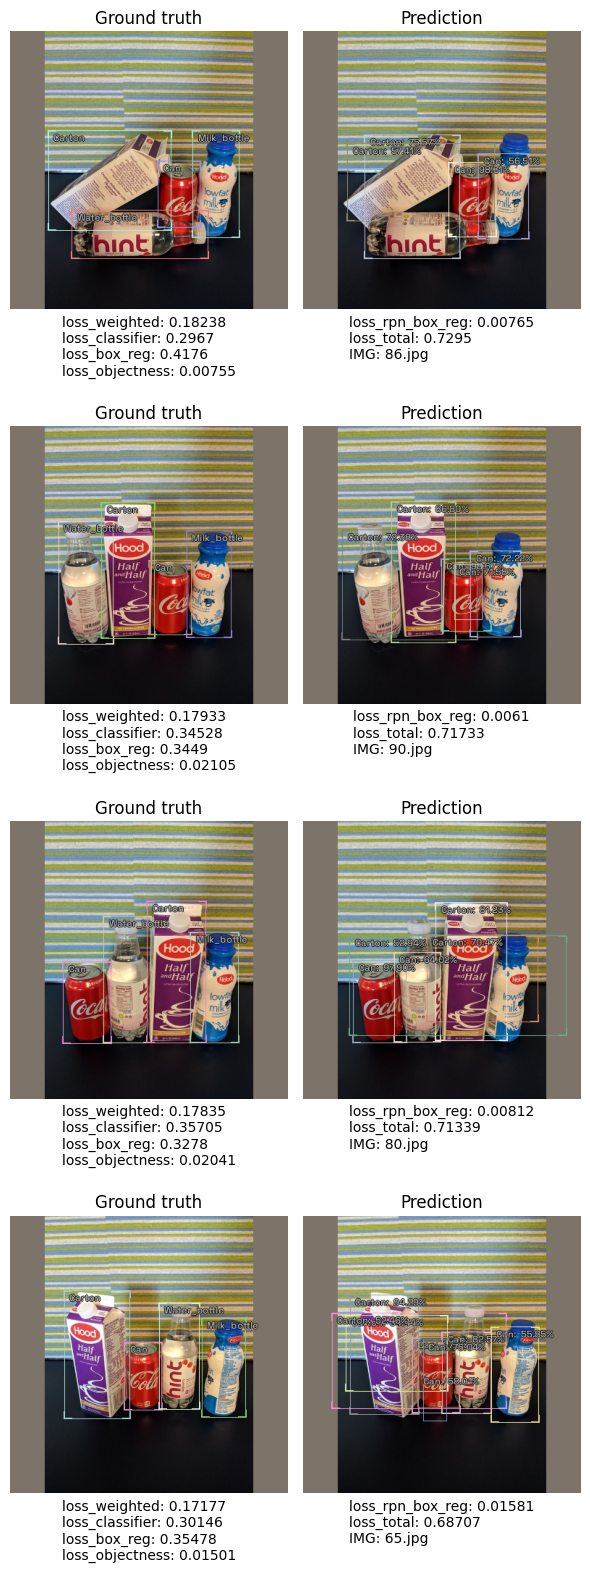

In [15]:
by = {
        "method": "weighted",
        "weights": {
            "loss_box_reg": 0.25,
            "loss_classifier": 0.25,
            "loss_objectness": 0.25,
            "loss_rpn_box_reg": 0.25,
        },
    }

samples_plus_losses, preds, losses_stats = model_type.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by=by, n_samples=4)

In [16]:
# `losses_stats` contains useful statistics for each computed loss in the dataset
losses_stats

{'loss_classifier': {'min': 0.06532751768827438,
  'max': 0.3570514917373657,
  'mean': 0.22153257807860008,
  '1ile': 0.06532751768827438,
  '25ile': 0.17143525183200836,
  '50ile': 0.23105227947235107,
  '75ile': 0.2811724841594696,
  '99ile': 0.3570514917373657},
 'loss_box_reg': {'min': 0.04955608770251274,
  'max': 0.41760146617889404,
  'mean': 0.24227395410147998,
  '1ile': 0.04955608770251274,
  '25ile': 0.16739314794540405,
  '50ile': 0.23787736147642136,
  '75ile': 0.3278003931045532,
  '99ile': 0.41760146617889404},
 'loss_objectness': {'min': 0.0017869938164949417,
  'max': 0.10180316120386124,
  'mean': 0.016076406804271616,
  '1ile': 0.0017869938164949417,
  '25ile': 0.007386505138128996,
  '50ile': 0.010415146127343178,
  '75ile': 0.018654515966773033,
  '99ile': 0.10180316120386124},
 'loss_rpn_box_reg': {'min': 0.001359554473310709,
  'max': 0.02417410910129547,
  'mean': 0.008536153078938905,
  '1ile': 0.001359554473310709,
  '25ile': 0.0056922342628240585,
  '50ile':

In [18]:
# we can easily extract losses per image and display them in a pandas DataFrame for further analysis

import pandas as pd
from icevision.models.interpretation import get_samples_losses

loss_per_image = get_samples_losses(samples_plus_losses)
pd.DataFrame(loss_per_image)

loss_classifier  loss_box_reg  loss_objectness  loss_rpn_box_reg  \
0          0.296700      0.417601         0.007554          0.007645   
1          0.345282      0.344900         0.021045          0.006102   
2          0.357051      0.327800         0.020415          0.008122   
3          0.301462      0.354785         0.015013          0.015807   
4          0.232049      0.370708         0.019768          0.010672   
5          0.296007      0.310065         0.014165          0.008247   
6          0.211539      0.393251         0.011715          0.006894   
7          0.271977      0.331191         0.012193          0.007269   
8          0.281172      0.282685         0.026252          0.014193   
9          0.260208      0.324138         0.008174          0.011745   
10         0.278057      0.261131         0.018655          0.007381   
11         0.235263      0.310668         0.002415          0.007940   
12         0.299006      0.214321         0.009115          0.011385   
13         0.230056      0.258252         0.008532          0.010260   
14         0.220261      0.210022         0.007387          0.005692   
15         0.171435      0.145327         0.101803          0.024174   
16         0.233022      0.204496         0.003368          0.001360   
17         0.202497      0.217503         0.008341          0.010180   
18         0.206598      0.164179         0.051936          0.015769   
19         0.145833      0.187863         0.018361          0.010626   
20         0.118557      0.171712         0.002909          0.001784   
21         0.103582      0.167393         0.014592          0.006817   
22         0.180912      0.102142         0.002801          0.002640   
23         0.118964      0.102546         0.007565          0.004681   
24         0.097024      0.074887         0.002125          0.002476   
25         0.065328      0.049556         0.001787          0.002080   

    loss_total  loss_weighted  \
0     0.729501       0.182375   
1     0.717329       0.179332   
2     0.713388       0.178347   
3     0.687068       0.171767   
4     0.633197       0.158299   
5     0.628484       0.157121   
6     0.623400       0.155850   
7     0.622630       0.155657   
8     0.604303       0.151076   
9     0.604265       0.151066   
10    0.565223       0.141306   
11    0.556287       0.139072   
12    0.533828       0.133457   
13    0.507099       0.126775   
14    0.443363       0.110841   
15    0.442740       0.110685   
16    0.442246       0.110562   
17    0.438521       0.109630   
18    0.438482       0.109621   
19    0.362683       0.090671   
20    0.294962       0.073740   
21    0.292384       0.073096   
22    0.288496       0.072124   
23    0.233756       0.058439   
24    0.176512       0.044128   
25    0.118751       0.029688   

                                                              filepath  
0    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/86.jpg  
1    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/90.jpg  
2    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/80.jpg  
3    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/65.jpg  
4    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/41.jpg  
5    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/81.jpg  
6    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/87.jpg  
7    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/48.jpg  
8    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/37.jpg  
9    /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/74.jpg  
10   /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/28.jpg  
11   /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/46.jpg  
12   /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/36.jpg  
13   /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/40.jpg  
14  /home/ubuntu/.icevision/data/fridge/odFridgeObjects/images/115.jpg  

## Run `top_plot_losses` on a `efficientdet` pretrained (but not finetuned) model

In [20]:
extra_args = {}
model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_lite0
# The efficientdet model requires an img_size parameter
extra_args['img_size'] = 384
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

INFO     - Losses returned by model: ['effdet_total_loss', 'class_loss', 'box_loss'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/ice/lib/python3.8/site-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


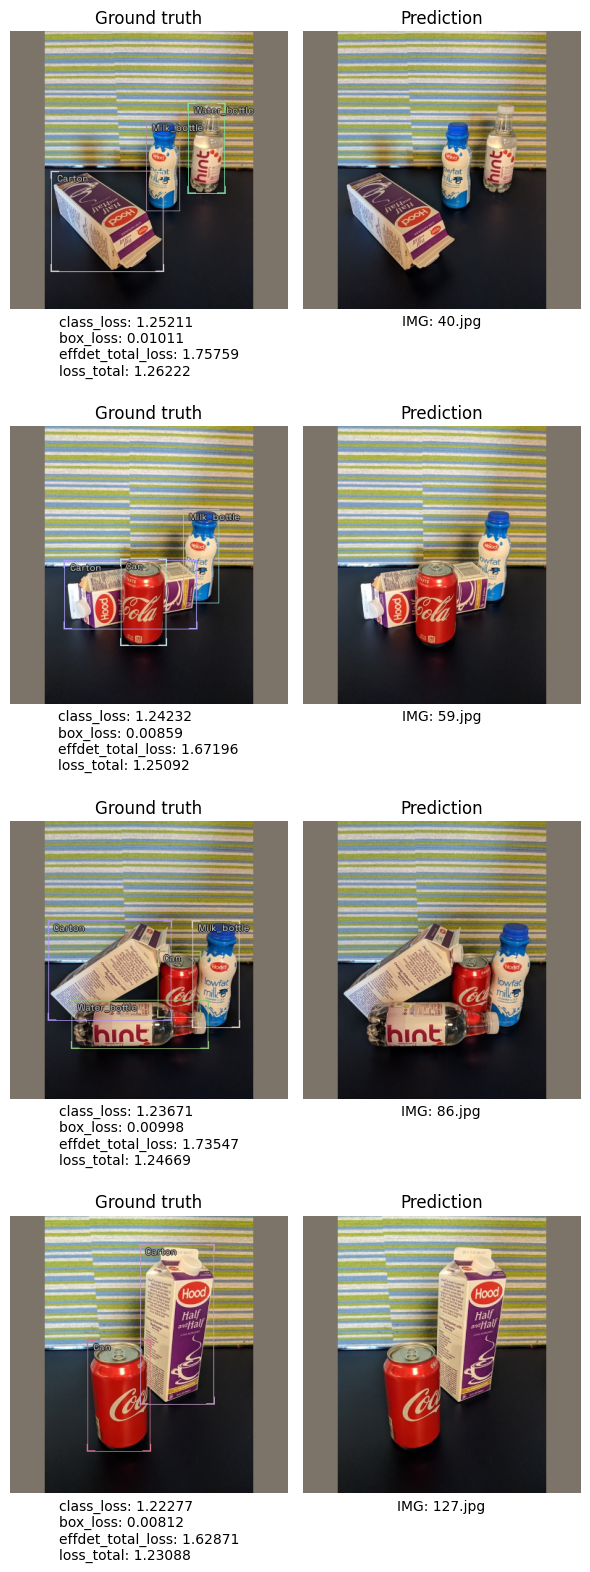

In [21]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="class_loss", n_samples=4)

# Instance Segmentation

## `plot_top_losses` in action with a `mask_rcnn` model on the `pennfudan` dataset

In [23]:
# Loading Data
data_dir = icedata.pennfudan.load_data()
parser = icedata.pennfudan.parser(data_dir)

In [24]:
# train_ds, valid_ds = icedata.pennfudan.dataset(data_dir)
train_rs, valid_rs = parser.parse()

  0%|          | 0/170 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/170 [00:00<?, ?it/s]

In [25]:
# Transforms
image_size = 512
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=1024), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

In [26]:
model_type = models.mmdet.mask_rcnn
backbone = model_type.backbones.resnet50_fpn_1x()

In [27]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=4, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=4, num_workers=4, shuffle=False)

In [ ]:
model = model_type.model(backbone=backbone, num_classes=icedata.pennfudan.NUM_CLASSES) 

In [29]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model)
learn.fine_tune(10, 3e-4, freeze_epochs=2)

/home/ubuntu/anaconda3/envs/ice/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/ubuntu/anaconda3/envs/ice/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


INFO     - Losses returned by model: ['loss_rpn_cls', 'loss_rpn_bbox', 'loss_cls', 'loss_bbox', 'loss_mask'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

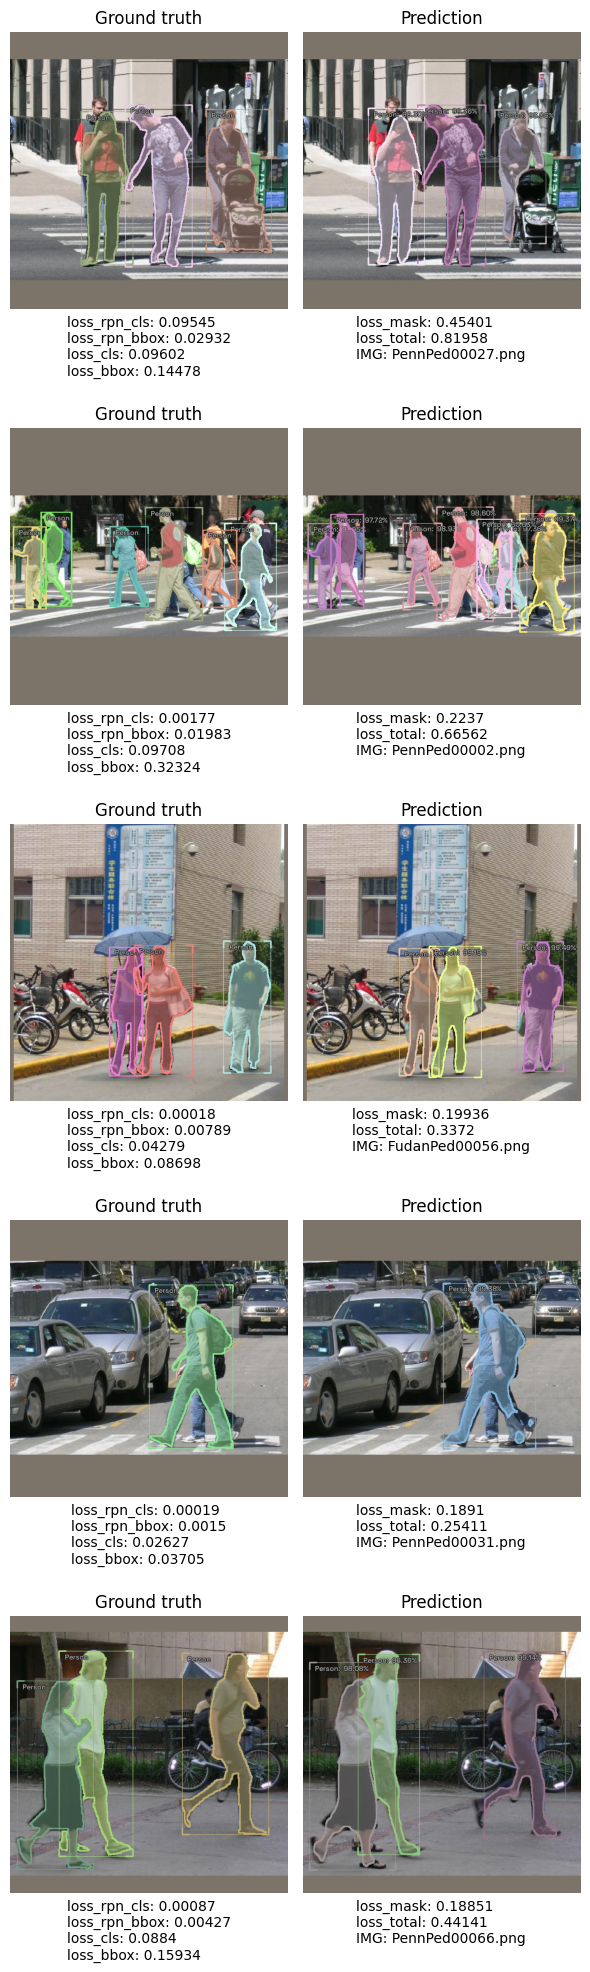

In [30]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="loss_mask")

# Keypoint Detection

## `plot_top_losses` in action with a `keypoint_rcnn` model on the `biwi` dataset

In [31]:
model_type = models.torchvision.keypoint_rcnn

In [32]:
data_dir = icedata.biwi.load_data()
parser = icedata.biwi.parser(data_dir)

train_records, valid_records = parser.parse()

presize = 240
size = 120

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(train_ds, batch_size=32, num_workers=4, shuffle=False)

  0%|          | 0/593774 [00:00<?, ?B/s]

  0%|          | 0/200 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/200 [00:00<?, ?it/s]

In [34]:
backbone = model_type.backbones.resnet18_fpn(pretrained=True)
model = model_type.model(backbone=backbone, num_keypoints=1)

In [35]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model)
learn.fine_tune(5, 1e-4, freeze_epochs=2)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'loss_keypoint'] | icevision.models.interpretation:plot_top_losses:218


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

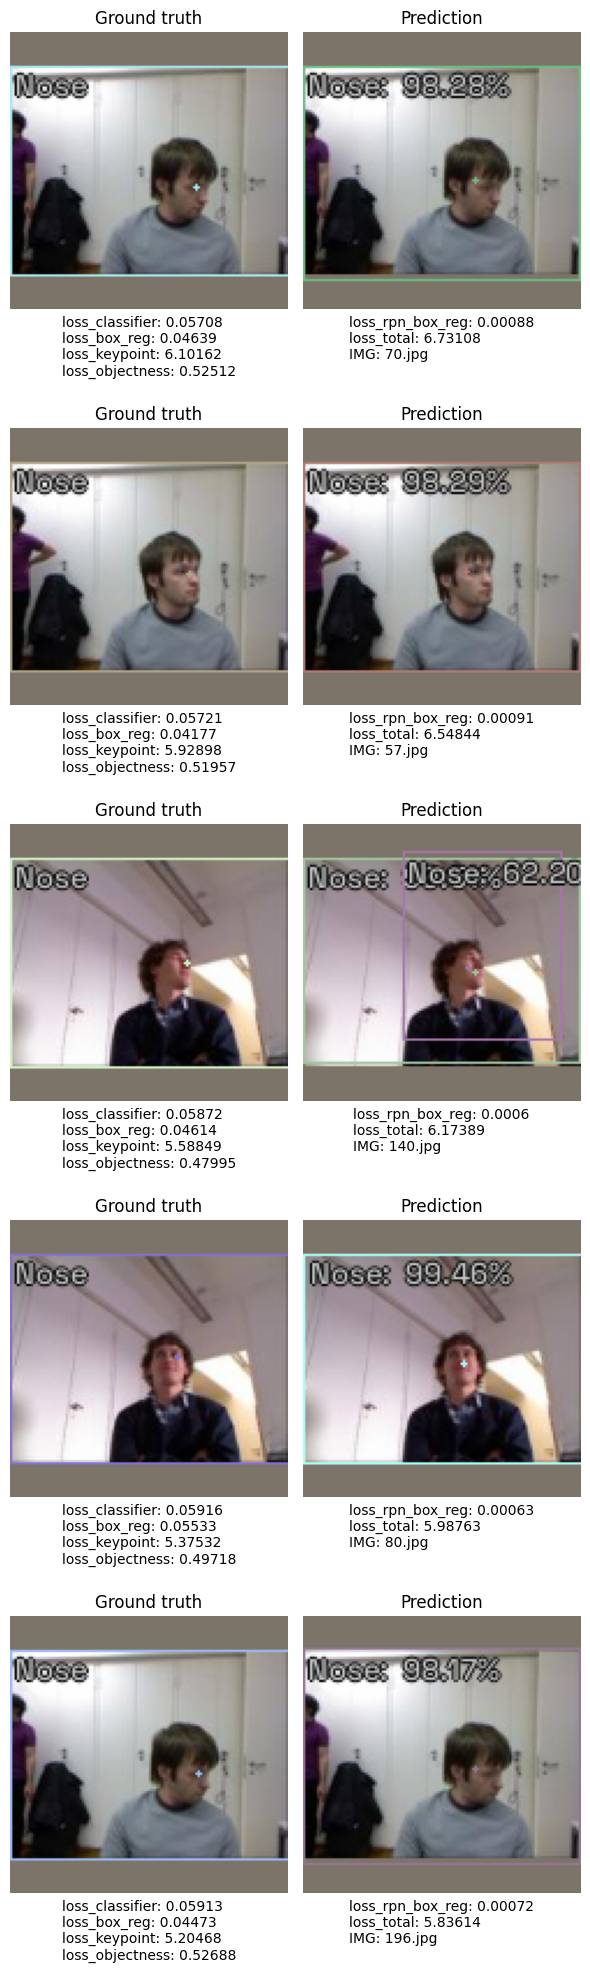

In [36]:
sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by="loss_keypoint")